In [36]:
# Includes libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

## I. Data Preprocessing

In [37]:
# Set the path to the data
path = "data/"

# Write data into a dataframe
dataframe = pd.DataFrame()

for file in os.listdir(path):
    read_df = pd.read_csv(path + file, sep = ",")
    read_df["Company"] = file.split("(")[0]
    dataframe = pd.concat([dataframe, read_df], axis=0)

# Sort the dataframe by date and reset the index
dataframe.sort_values(by=["Date"], inplace=True)
dataframe.reset_index(drop=True, inplace=True)

# Convert the date column to datetime required for time series split
dataframe["Date"] = pd.to_datetime(dataframe["Date"])

dataframe.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Company
0,2013-01-02,8.815092,9.005301,8.740256,8.824447,8.824447,1742042,ZG
1,2013-01-02,44.980000,45.000000,44.220001,44.660000,33.821247,31413000,JPM
2,2013-01-02,20.120001,20.340000,20.010000,20.340000,14.881187,40304500,CSCO
3,2013-01-02,68.930000,69.239998,68.449997,69.239998,55.454224,10390800,WMT
4,2013-01-02,21.150000,21.379999,21.049999,21.379999,15.855695,47623000,INTC


In [38]:
print(f"Total number of missing values: {dataframe.isnull().sum().sum()}")
dataframe.describe()

Total number of missing values: 0


,Open,High,Low,Close,Adj Close,Volume
count,73483.000000,73483.000000,73483.000000,73483.000000,73483.000000,7.348300e+04
mean,78.064760,79.031414,77.048285,78.056760,74.754774,3.238935e+07
std,75.567092,76.585377,74.453266,75.533542,75.806397,4.960662e+07
min,1.620000,1.690000,1.610000,1.620000,1.620000,0.000000e+00
25%,28.322241,28.642882,27.998296,28.318129,25.045510,6.260150e+06
50%,52.904999,53.566002,52.200001,52.900002,49.549500,1.713930e+07
75%,102.000000,103.134998,100.814999,102.029999,97.802342,3.805548e+07
max,692.349976,700.989990,686.090027,691.690002,691.690002,1.460852e+09


In [39]:
# Label encode the company column
enc = OneHotEncoder(handle_unknown="error")
company_encoded = enc.fit_transform(dataframe[["Company"]]).toarray()
df_company_encoded = pd.DataFrame(company_encoded, columns=enc.get_feature_names_out())
dataframe_enc = pd.concat([dataframe, df_company_encoded], axis=1)
dataframe_enc.drop(["Company"], axis=1, inplace=True)

In [40]:
dataframe_enc.describe()

,Open,High,Low,Close,Adj Close,Volume,Company_AAPL,Company_AMD,Company_AMZN,Company_ATVI,...,Company_NVDA,Company_PFE,Company_PYPL,Company_T,Company_TSLA,Company_TTD,Company_WMT,Company_XOM,Company_YELP,Company_ZG
count,73483.000000,73483.000000,73483.000000,73483.000000,73483.000000,7.348300e+04,73483.000000,73483.000000,73483.000000,73483.000000,...,73483.000000,73483.000000,73483.000000,73483.000000,73483.000000,73483.000000,73483.000000,73483.000000,73483.000000,73483.000000
mean,78.064760,79.031414,77.048285,78.056760,74.754774,3.238935e+07,0.034266,0.034266,0.034266,0.034266,...,0.034266,0.034266,0.025679,0.034266,0.034266,0.021502,0.034266,0.034266,0.034266,0.034266
std,75.567092,76.585377,74.453266,75.533542,75.806397,4.960662e+07,0.181914,0.181914,0.181914,0.181914,...,0.181914,0.181914,0.158178,0.181914,0.181914,0.145050,0.181914,0.181914,0.181914,0.181914
min,1.620000,1.690000,1.610000,1.620000,1.620000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.322241,28.642882,27.998296,28.318129,25.045510,6.260150e+06,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,52.904999,53.566002,52.200001,52.900002,49.549500,1.713930e+07,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,102.000000,103.134998,100.814999,102.029999,97.802342,3.805548e+07,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,692.349976,700.989990,686.090027,691.690002,691.690002,1.460852e+09,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [41]:
# Split the data into train, test and validation sets. Note that the data is not shuffled to preserve the time series order
X = dataframe_enc.drop(["Close", "Adj Close", "Date"], axis=1)
y = dataframe_enc["Close"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3, shuffle=True)

(X_train.shape, y_train.shape), (X_val.shape, y_val.shape), (X_test.shape, y_test.shape)

(((51438, 34), (51438,)), ((15431, 34), (15431,)), ((6614, 34), (6614,)))

In [42]:
# Standardize the data
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

The number of principal components is: 34


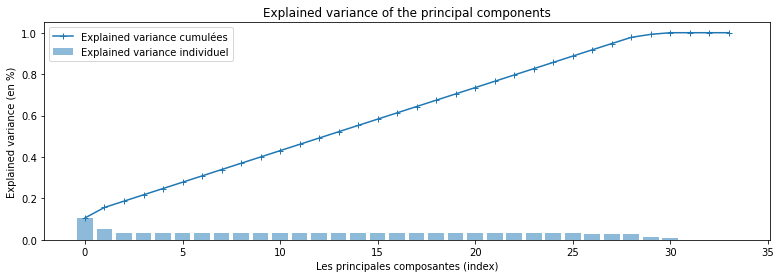

In [43]:
# Application of the PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
print(f"The number of principal components is: {pca.n_components_}")

# Visualization of the explained variance of the principal components
exp_var_pca = pca.explained_variance_ratio_

plt.figure(figsize=(13, 4))
plt.bar(range(len(exp_var_pca)), height=exp_var_pca, label="Explained variance individuel", alpha=.5)
plt.plot(np.cumsum(exp_var_pca), marker="+", label="Explained variance cumulées")
plt.xlabel("Les principales composantes (index)")
plt.ylabel("Explained variance (en %)")
plt.title("Explained variance of the principal components")
plt.legend()
plt.show()

After analysing the above graph, we can see that the best n_components is 29, because after that the explained variance is almost constant.

In [44]:
# Application of the PCA with 29 components
pca = PCA(n_components=29)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

## II. Data Visualization

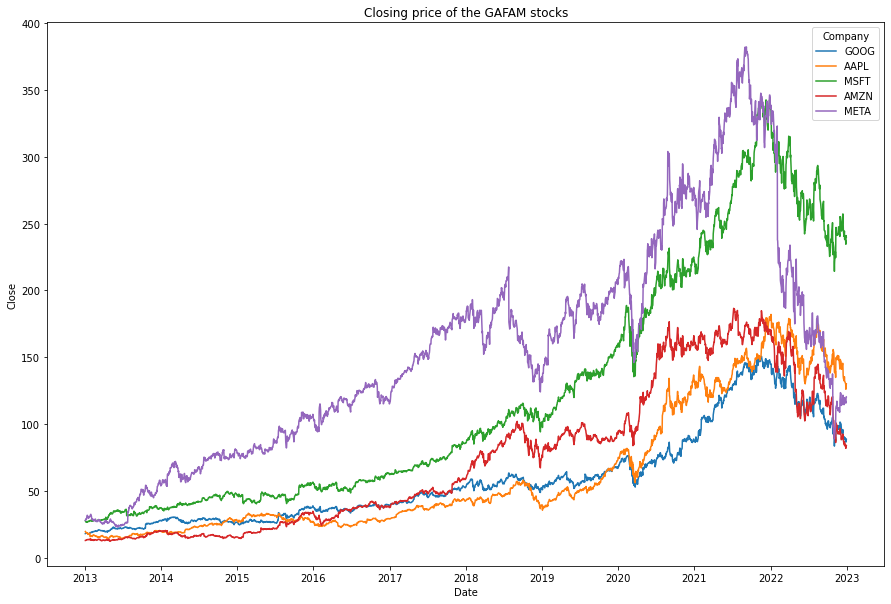

In [45]:
GAFAM = ["GOOG", "AMZN", "META", "AAPL", "MSFT"]
GAFAM = dataframe[dataframe["Company"].isin(GAFAM)]

# Plot the closing price of the GAFAM stocks
plt.figure(figsize=(15, 10))
sns.lineplot(x="Date", y="Close", hue="Company", data=GAFAM)
plt.title("Closing price of the GAFAM stocks")
plt.show()

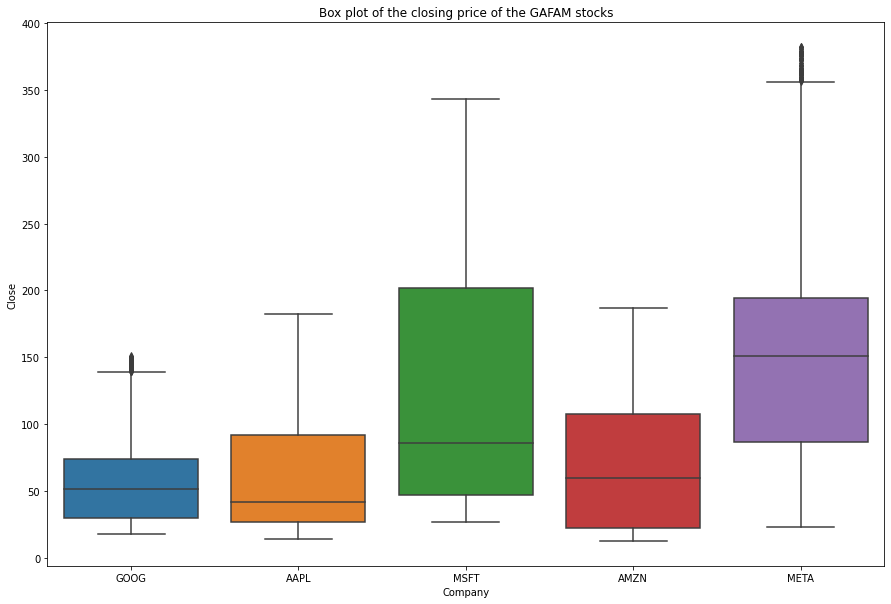

In [46]:
# Plot the box plot
plt.subplots(figsize=(15, 10))
sns.boxplot(x="Company", y="Close", data=GAFAM)
plt.title("Box plot of the closing price of the GAFAM stocks")
plt.show()

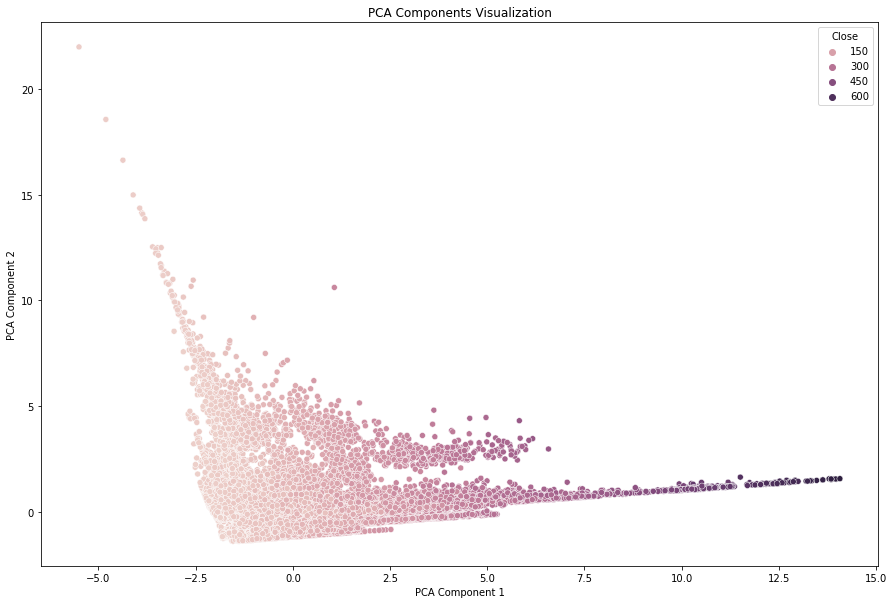

In [47]:
# PCA Components Visualization
plt.figure(figsize=(15, 10))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train)
plt.title("PCA Components Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

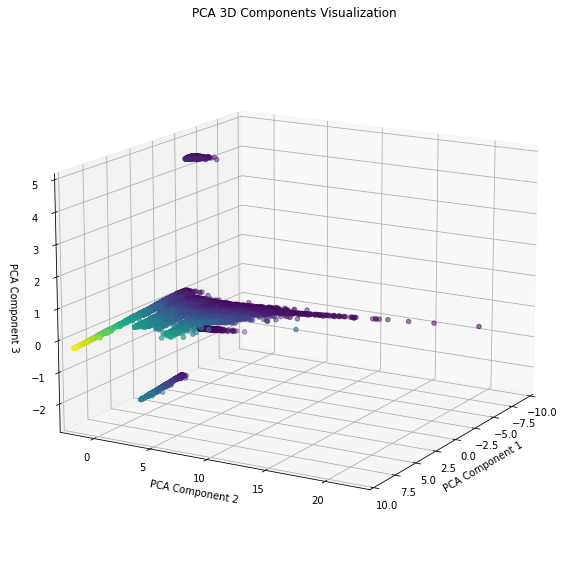

In [48]:
# PCA 3D Components Visualization
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c=y_train)
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.set_xlim(-10, 10)
ax.view_init(15, 30)
plt.title("PCA 3D Components Visualization")
plt.show()

## III. Regression Model

### 1. Linear Regression

In [49]:
# Train the model
lr = LinearRegression()
cr = lr.fit(X_train_pca, y_train)

print(f"MSE Train: {mean_squared_error(y_train, cr.predict(X_train_pca))}")
print(f"MSE Valid: {mean_squared_error(y_val, cr.predict(X_val_pca))}")

MSE Train: 171.55571588341905
MSE Valid: 175.38879343082206


In [50]:
lr = LinearRegression()

# Cross validation
scores = cross_val_score(lr, X_train_pca, y_train, cv=5)
print(f"Cross validation scores: {scores}")


Cross validation scores: [0.97024739 0.97072126 0.96926291 0.96986428 0.9693057 ]


In [51]:
from sklearn.ensemble import RandomForestRegressor

### 2. RandomForest Regressor

In [53]:
### random forest regressor

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)
rf.fit(X_train_pca, y_train)

print(f"MSE Train: {mean_squared_error(y_train, rf.predict(X_train_pca))}")
print(f"MSE Valid: {mean_squared_error(y_val, rf.predict(X_val_pca))}")


# mean absolute error
from sklearn.metrics import mean_absolute_error

print(f"MAE Train: {mean_absolute_error(y_train, rf.predict(X_train_pca))}")
print(f"MAE Valid: {mean_absolute_error(y_val, rf.predict(X_val_pca))}")




MSE Train: 3.121059490570384
MSE Valid: 4.671549068463174
MAE Train: 1.1839206688048236
MAE Valid: 1.3475117743890206


In [55]:
## gride search cv

from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 50, 100],
    'max_features': [2, 3],
    'n_estimators': [100, 500]
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train_pca, y_train)

grid_search.best_params_

best_grid = grid_search.best_estimator_

print(f"MSE Train: {mean_squared_error(y_train, best_grid.predict(X_train_pca))}")
print(f"MSE Valid: {mean_squared_error(y_val, best_grid.predict(X_val_pca))}")

print(f"MAE Train: {mean_absolute_error(y_train, best_grid.predict(X_train_pca))}")
print(f"MAE Valid: {mean_absolute_error(y_val, best_grid.predict(X_val_pca))}")



Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/thomassinapi/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


MSE Train: 0.3747747528875081
MSE Valid: 2.4892927904679873
MAE Train: 0.2821705877224779
MAE Valid: 0.7491894312757156
